# Store Sales Forecasting
---
### MIS 381N: Group Project, Summer 2022
### Group Members - Prathmesh Savale, Juwon Lee, Bolun Zhang, Vivek Dhullipala


## Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import statsmodels as sm
import statsmodels.api as sm_api

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

import contextlib
import warnings

import copy 
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

from datetime import date, timedelta
import datetime

from tslearn.clustering import TimeSeriesKMeans
# try:
#   !pip install pystan~=2.14
#   !pip install fbprophet
# except:
#   pass

ModuleNotFoundError: No module named 'tslearn'

In [ ]:
# filter simple warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import os
os.getcwd()

## Reading Datasets

In [ ]:
try:
    train = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/test.csv')
    oil = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/oil.csv')
    stores = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/stores.csv')
    transactions = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/transactions.csv')
    holiday_events = pd.read_csv('/content/drive/MyDrive/MIS_group_project_store_sales/holidays_events.csv')
except:
    train = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/train.csv')
    test = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/test.csv')
    oil = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/oil.csv')
    stores = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/stores.csv')
    transactions = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/transactions.csv')
    holiday_events = pd.read_csv('/home/praths/notebooks/MIS/group_project/MIS_group_project/holidays_events.csv')

In [ ]:
train_backup = copy.deepcopy(train)
test_backup = copy.deepcopy(test)

In [ ]:
train.head(3)

In [ ]:
test.head(3)

In [ ]:
min(train['date']), max(train['date']), min(test['date']), max(test['date'])

In [ ]:
train['family'].value_counts().shape, train['store_nbr'].value_counts().shape

In [ ]:
train['family'].unique(), train['store_nbr'].unique()

## Data preprocessing
---
* checking datasets that can be used for analysis and modelling
* checking NULL values across all datasets 
* treating NULL values
* Joining train and test datasets with 

In [ ]:
holiday_events['holiday_present'] = 1
holiday_events.rename(columns={'type' : 'holiday_type'}, inplace=True)
holiday_events_df = holiday_events[['date','holiday_present','holiday_type']]

In [ ]:
train_id_dropped = train.drop('id', axis=1)
train_df = pd.merge(train_id_dropped, holiday_events, on='date', how='left')
train_df.loc[train_df['holiday_present'].isna(), 'holiday_type'] = 'not_holiday'
train_df.loc[train_df['holiday_present'].isna(), 'holiday_present'] = 0

In [ ]:
train_df.isnull().sum()

In [ ]:
oil = oil.fillna(method='bfill')
train_holiday_oil_df = pd.merge(train_df, oil, on='date', how='left')
train_holiday_oil_df['dcoilwtico'].fillna(method='bfill', inplace=True)

In [ ]:
train_holiday_oil_df.head(5)

In [ ]:
# locale_name, description, transferred holiday etc. are ignored
train_holiday_oil_df.isnull().sum()

In [ ]:
train_holiday_oil_df = train_holiday_oil_df[['date', 'store_nbr', 'family', 'sales', 'onpromotion', \
                                             'holiday_type', 'holiday_present', 'dcoilwtico']]

## Exploratory data analysis
---
*   Checking time trends across stores and product families


In [1]:
# sales across stores seem to have similar trends at a daily level with occasional spikes
train_holiday_oil_df[['sales', 'store_nbr', 'date']].groupby(['store_nbr','date']).agg({'sales':'sum'})\
.unstack().transpose().plot(figsize=(20,15))

NameError: name 'train_holiday_oil_df' is not defined

In [23]:
# sales across stores seem to have similar trends at a daily level with occasional spikes
stores_ts_sales = train_holiday_oil_df[['sales', 'store_nbr', 'date']].groupby(['store_nbr','date']).agg({'sales':'sum'})\
.unstack()

In [42]:
%%time
ts_clust_fit_stores = TimeSeriesKMeans(n_clusters=3, metric="dtw",
                         max_iter=10, random_state=101).fit(stores_ts_sales)

KeyboardInterrupt: 

In [43]:
%%time
predicted_ts_clusters = ts_clust_fit_stores.predict(stores_ts_sales)

CPU times: user 9.73 s, sys: 1.08 ms, total: 9.73 s
Wall time: 9.73 s


In [27]:
clusters_df_stores = pd.Series(predicted_ts_clusters, index=stores_ts_sales.index, name='cluster')
cluster_stores_ts = stores_ts_sales.merge(clusters_df_stores.to_frame(), left_index=True, right_index=True)

In [28]:
cluster_stores_ts['cluster'].value_counts()

0    35
3    12
1     5
2     2
Name: cluster, dtype: int64

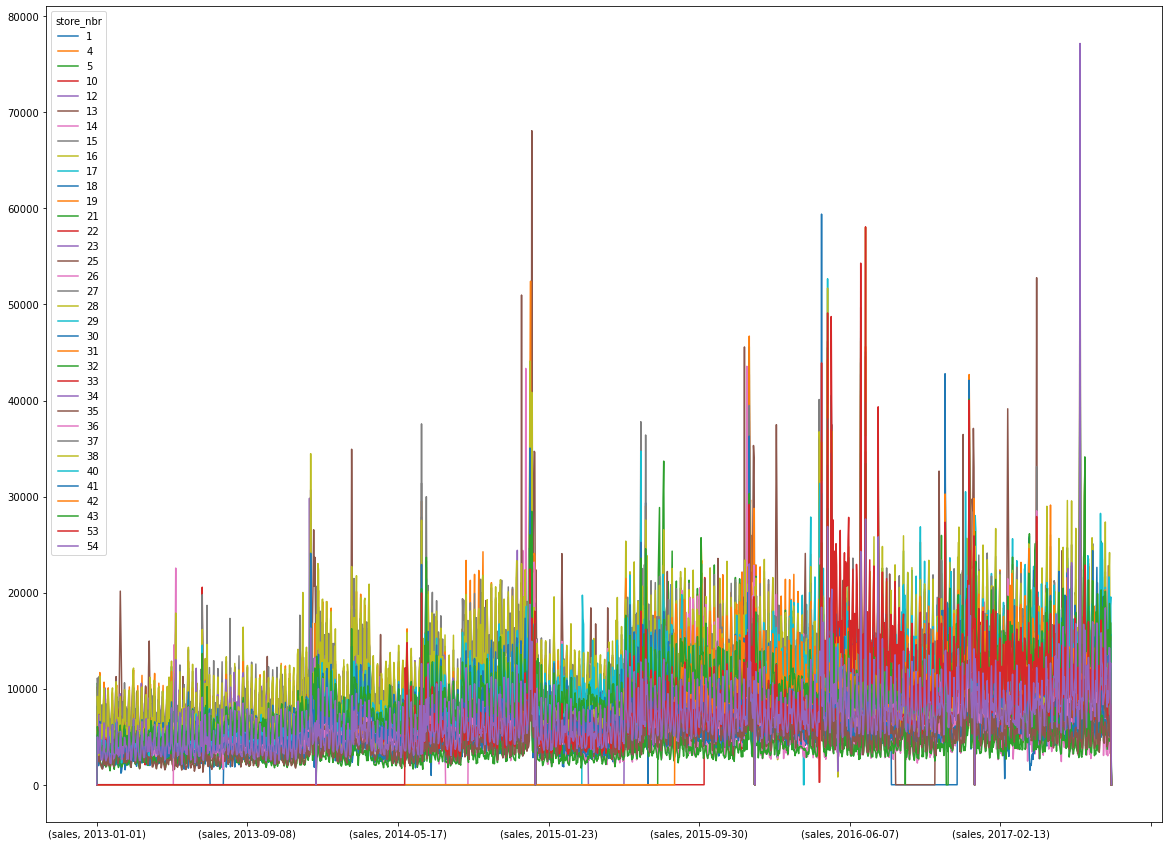

In [30]:
cluster_stores_ts[cluster_stores_ts['cluster'] == 0].transpose().plot(figsize=(20,15))

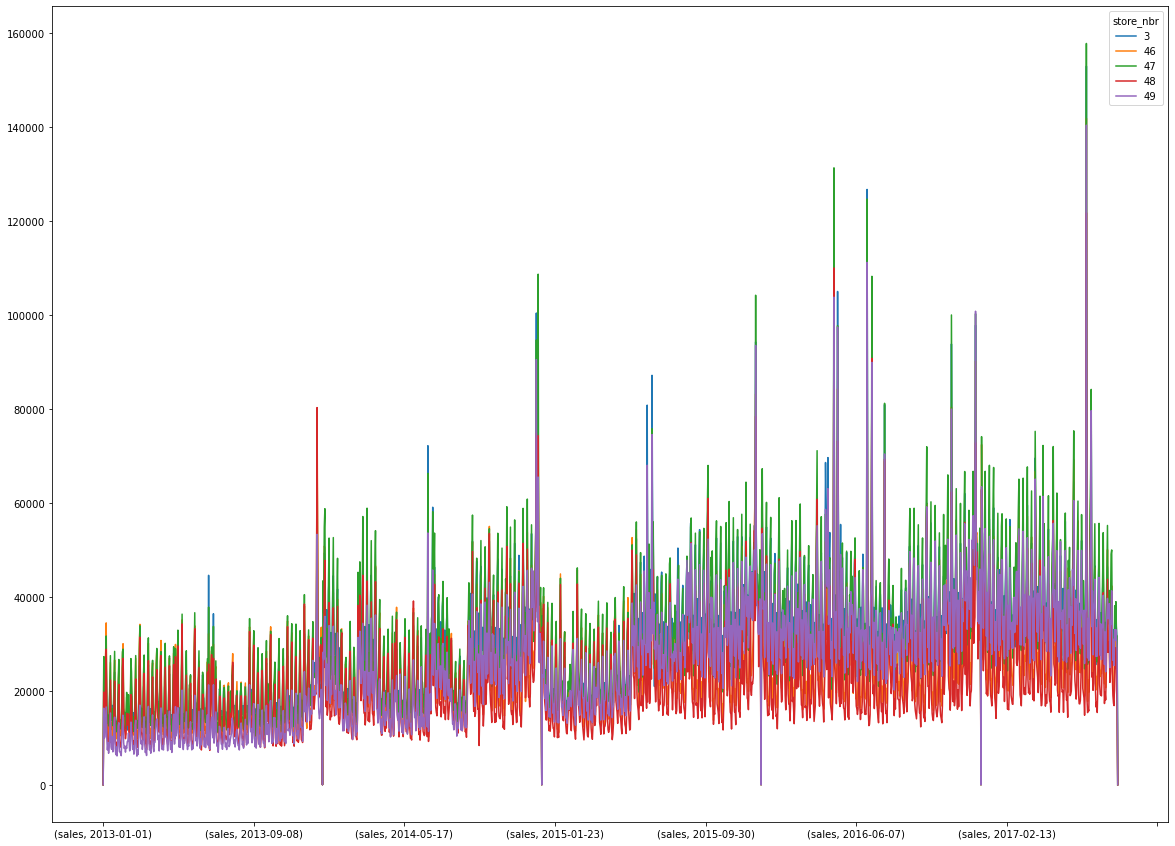

In [31]:
cluster_stores_ts[cluster_stores_ts['cluster'] == 1].transpose().plot(figsize=(20,15))

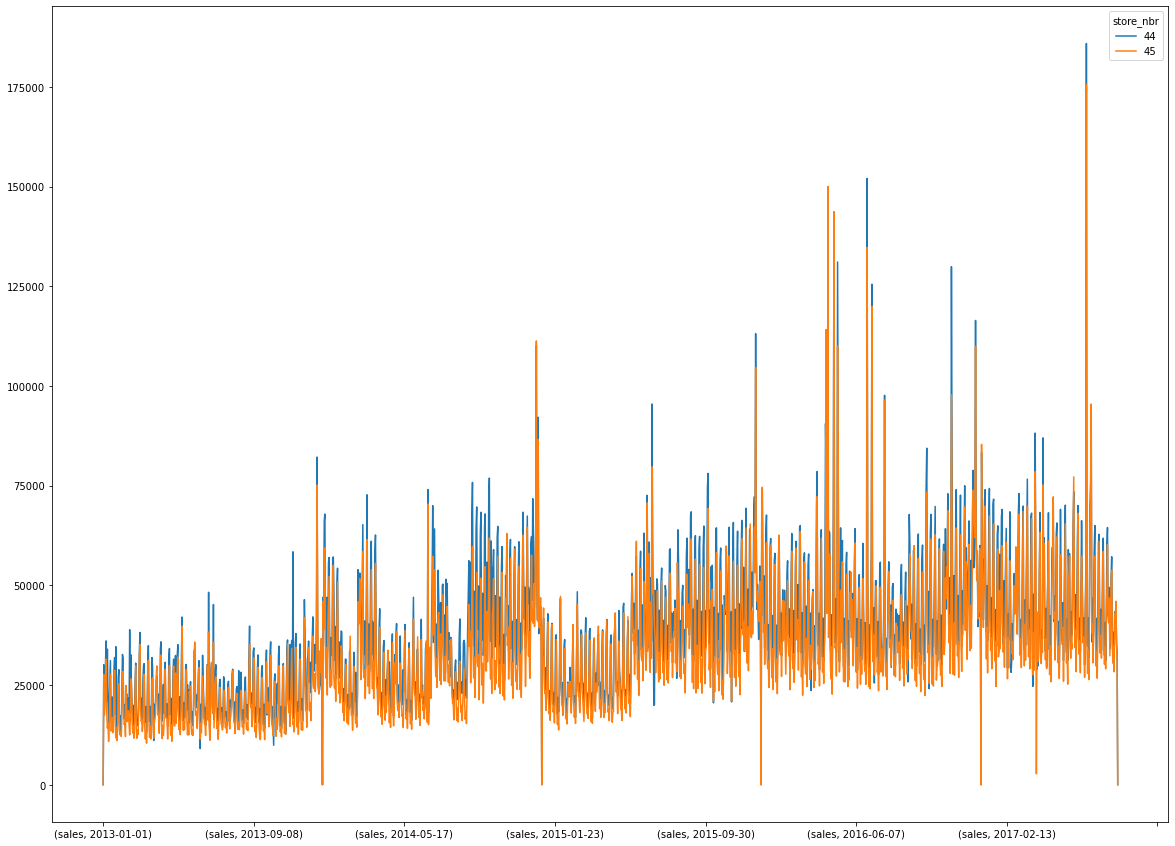

In [32]:
cluster_stores_ts[cluster_stores_ts['cluster'] == 2].transpose().plot(figsize=(20,15))

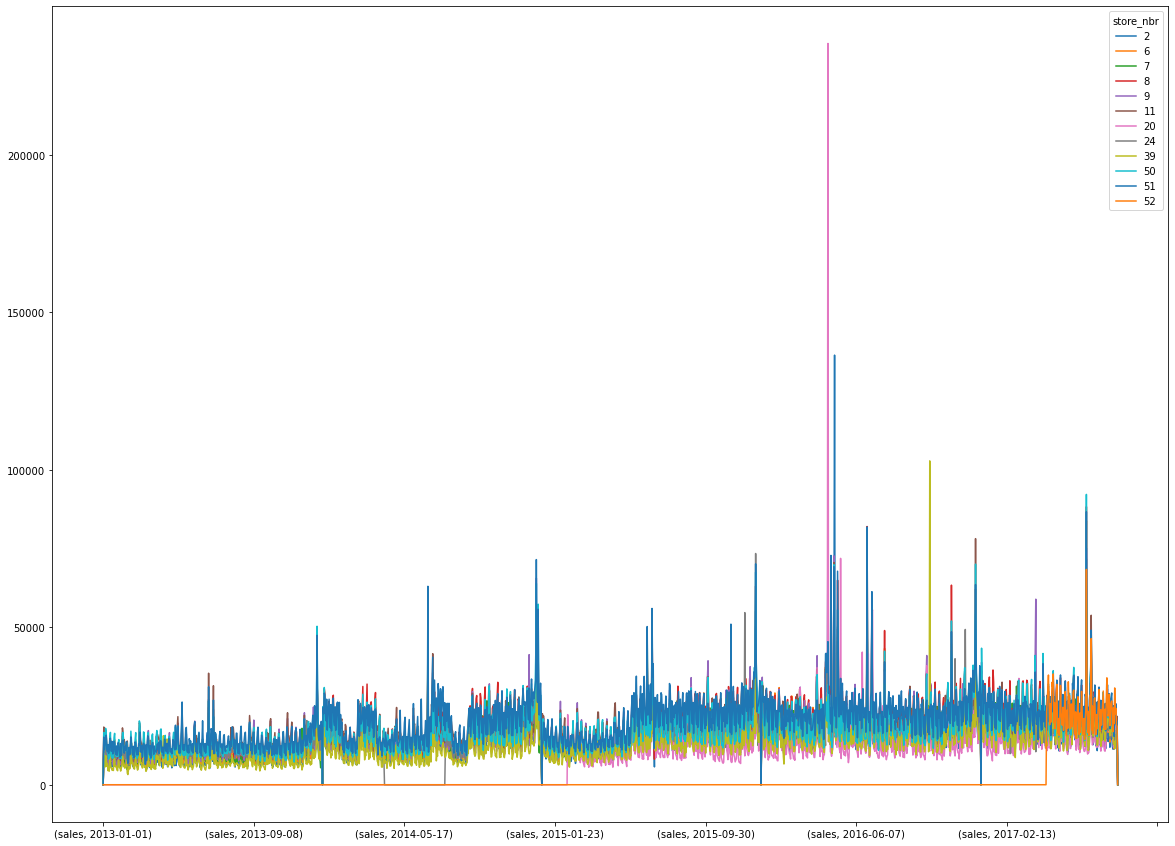

In [33]:
cluster_stores_ts[cluster_stores_ts['cluster'] == 3].transpose().plot(figsize=(20,15))

### product family

In [ ]:
train_holiday_oil_df[['sales', 'family', 'date']].groupby(['family','date']).agg({'sales':'sum'})\
.unstack().transpose().plot(figsize=(20,15))

In [ ]:
family_ts_sales = train_holiday_oil_df[['sales', 'family', 'date']].groupby(['family','date']).agg({'sales':'sum'})\
.unstack()

In [44]:
%%time
ts_clust_fit_family = TimeSeriesKMeans(n_clusters=3, metric="dtw",
                         max_iter=10, random_state=101).fit(family_ts_sales)

NameError: name 'family_ts_sales' is not defined

In [45]:
%%time
predicted_ts_clusters = ts_clust_fit_family.predict(family_ts_sales, seed=107)

NameError: name 'ts_clust_fit_family' is not defined

In [ ]:
clusters_df_family = pd.Series(predicted_ts_clusters, index=test_dtw.index, name='cluster')
cluster_family_ts = test_dtw.merge(clusters_df_family.to_frame(), left_index=True, right_index=True)

In [ ]:
cluster_family_ts['cluster'].value_counts()

In [ ]:
cluster_family_ts[cluster_family_ts['cluster'] == 0].transpose().plot(figsize=(20,15))

In [ ]:
cluster_family_ts[cluster_family_ts['cluster'] == 1].transpose().plot(figsize=(20,15))

In [ ]:
cluster_family_ts[cluster_family_ts['cluster'] == 2].transpose().plot(figsize=(20,15))

In [ ]:
cluster_family_ts[cluster_family_ts['cluster'] == 3].transpose().plot(figsize=(20,15))

# Checking impact of oil at overall level
* train test split for modelling

In [ ]:
train_holiday_oil_grouped_by_date  = train_holiday_oil_df.groupby('date')[['sales','dcoilwtico','holiday_present']].agg({'sales':'sum', 'dcoilwtico':'mean' , 'holiday_present':'max'})

In [ ]:
# making a 80:20 split for train and validation
train_validation_cutoff = int(train_holiday_oil_grouped_by_date.shape[0]*0.8)
train_holiday_oil_grouped_by_date.index = train_holiday_oil_grouped_by_date.index.map(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))
train = train_holiday_oil_grouped_by_date.iloc[:train_validation_cutoff]
validation = train_holiday_oil_grouped_by_date.iloc[train_validation_cutoff:]

In [ ]:
# plotting this takes too much time, skip this cell
sns.set(rc = {'figure.figsize':(15,8)})
fig, ax = plt.subplots()
ax= sns.lineplot(x=train.index, y='sales', data=train)
# adding secondary axis for oil
ax1 = ax.twinx()
ax1 = sns.lineplot(x=train.index, y='dcoilwtico', data=train, color='red', ci=None)
# strong negative correlation between sales and oil prices

## STL decomposition and running the forecast - overall level

In [ ]:
# converting dataframe to time series and decomposing to trend, seasonal and residue
train_ts = pd.Series(train['sales'], index=train.index)
tsdecomposed = seasonal_decompose(train_ts, model='additive', freq=365)

In [ ]:
tsdecomposed.plot()

In [ ]:
trend = tsdecomposed.trend
seasonality = tsdecomposed.seasonal

trend_filled_forward = trend.ffill().bfill()

residual = train_ts - trend_filled_forward - seasonality

In [ ]:
# create time index for prediction
from pandas.core.indexes.datetimes import date_range
preds = pd.Series(0, index=date_range(start=max(train.index), periods=validation.shape[0]))

In [ ]:
# calculating time deltas
max(train.index), max(train.index)- timedelta(365)

In [ ]:
# forecasting seasonality
# get seasonality factors for past 1 year and propogate the seasonality
seasonality_forward = seasonality[seasonality.index > max(train.index) - timedelta(365)]
# create timestamp index from past 1 year to date
seasonality_forward.index = seasonality_forward.index + timedelta(365)

In [ ]:
# forecasting trend
# propogate the trend (this is calculated using centered mean - so initial and end values are absent)
trend_filled_forward = trend.ffill().bfill()
# create timestamp index from past 1 year to date
trend_filled_forward.index = trend_filled_forward.index + timedelta(365)

In [ ]:
# add propogated trend and forecast
forecast = seasonality_forward + trend_filled_forward

In [ ]:
def calc_mape(actual, forecast):
    return (1/len(actual))*(np.abs(sum(actual - forecast)))/sum(actual) * 100

In [ ]:
mape_cal = validation.merge(pd.Series(forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [ ]:
calc_mape(mape_cal['sales_actual'], mape_cal['sales_forecast']) # this is a really good mape value but it can be still improved by using forecastig residue

In [ ]:
%%time
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_cal['sales_actual'], x=mape_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_cal['sales_forecast'], x=mape_cal['sales_forecast'].index, color='green', label = 'forecast')

### Forecasting residue - Overall level

In [ ]:
external_merged = residual.to_frame().merge(train, left_index=True, right_index=True)

In [ ]:
# regressing the holiday variable against sales to calculate betas for effects
X = np.array(external_merged['holiday_present'])
X = sm_api.add_constant(X)
Y = np.array(external_merged[0])
ols = sm.regression.linear_model.OLS(X, Y)
ols_fit = ols.fit()
beta_val = ols_fit.params[0][1]

In [ ]:
# scaling sales based on the holiday variables and removing its effect
residual = external_merged.apply(lambda x: x[0] - x[0]*beta_val if x['holiday_present'] == 1 else x[0] ,axis=1)

In [ ]:
history = [x for x in residual.dropna()]
# plt.plot(history)
predictions = list()
for t in range(len(validation)):
    model = sm_api.tsa.ARIMA(history, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = validation.sales[t]
    history.append(obs)

In [ ]:
mape = np.sqrt(calc_mape(validation['sales'], np.array(predictions).ravel()))
mape

In [ ]:
sales_pred_series = pd.Series(np.array(predictions).ravel(), name='sales_prediction', index=validation.index)

In [ ]:
external_merged_post = sales_pred_series.to_frame().merge(validation, left_index=True, right_index=True)

In [ ]:
predictions_corrected = external_merged_post.apply(lambda x: x['sales_prediction'] + x['sales_prediction'] * beta_val if x['holiday_present'] == 1 else x['sales_prediction'] ,axis=1)

In [ ]:
forecast1 = seasonality_forward + trend_filled_forward + pd.Series(np.array(predictions_corrected).ravel(), index=validation.index)

In [ ]:
ax4 = plt.subplots(figsize=(20,10))
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=validation['sales'], x=validation.index, color='red', label='validation')
sns.lineplot(y=forecast1, x=forecast1.index, color='green', label = 'forecast')

In [ ]:
mape_cal2 = validation.merge(pd.Series(forecast1.dropna(), name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [ ]:
calc_mape(mape_cal2['sales_actual'], mape_cal2['sales_forecast']) # mape has reduced significantly

# Spark execution for across stores and products

In [ ]:
# https://www.pauldesalvo.com/how-to-install-spark-on-google-colab/

# !sudo apt update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
# !tar xf /content/spark-3.0.3-bin-hadoop3.2.tgz
# !pip install -q findspark
# !pip install pyspark

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

# !pip3 install pyarrow

import findspark
findspark.init()
findspark.find()

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

from pyspark.sql.functions import col, struct, next_day, date_sub, collect_list, array, lit, explode, min, max, first, last
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType, sum, max, col, concat, lit
import sys
import os
from fbprophet import Prophet

import statsmodels.tsa.api as sm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from pandas.core.indexes.datetimes import date_range

In [ ]:
spark = SparkSession.builder.appName("sales_forecasting_psavale").master("local[*]").getOrCreate()
sc = spark.sparkContext
sc.setSystemProperty("spark.dynamicAllocation.enabled", "true")
sc.setSystemProperty('spark.shuffle.service.enabled', "true")
sc.setSystemProperty("spark.speculation", "true")
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
sc.setSystemProperty("spark.driver.memory", "2G")
sc.setSystemProperty("spark.executor.memory", "8G")
sc.setSystemProperty("spark.executor.cores", "2")
sc.setSystemProperty("spark.executor.instances", "20")
sc.setSystemProperty("spark.sql.shuffle.partitions", "400")

In [ ]:
spark

In [ ]:
spark.sparkContext.getConf().get("spark.serializer")

### Train test stratified split

In [ ]:
# train_holiday_oil_df

In [ ]:
family=list(set(train_holiday_oil_df['family']))
store_nbr=list(set(train_holiday_oil_df['store_nbr']))

In [ ]:
train_holiday_oil_df.head(5)

In [ ]:
train_validation_df = train_holiday_oil_df[['date', 'store_nbr', 'family','sales', 'onpromotion', 'holiday_present']]

In [ ]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['sales']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['sales']).iloc[size:]
    y_train=data['sales'].iloc[0:size] 
    y_test=data['sales'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [ ]:
# %%time

try:
    
    X_train= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_train.pkl")
    X_test= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_test.pkl")
    Y_train= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_train.pkl")
    Y_test= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_test.pkl")

except:
  # this takes a long time to compute
  # loop each family and store number split the data into train and test data
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    for i in range(0,len(family)):
        for j in range(0, len(store_nbr)):
            df = train_validation_df[(train_validation_df['family']==family[i]) & (train_validation_df['store_nbr']==store_nbr[j])]
            x_train, x_test,y_train,y_test=train_test_split(df)
            X_train.append(x_train)
            X_test.append(x_test)
            Y_train.append(y_train)
            Y_test.append(y_test)
    X_train=pd.concat(X_train)
    Y_train=pd.DataFrame(pd.concat(Y_train))
    X_test=pd.concat(X_test)
    Y_test=pd.DataFrame(pd.concat(Y_test))

    X_train.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_train.pkl")
    X_test.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_test.pkl")
    Y_train.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_train.pkl")
    Y_test.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_test.pkl")

In [ ]:
schema = StructType([
        StructField('date', StringType(), True),
        StructField('store_nbr', IntegerType(), True),
        StructField('family', StringType(), True),
        StructField('sales', DoubleType(), True),
        StructField('onpromotion', IntegerType(), True),
        StructField('holiday_present', DoubleType(), True),
        StructField('forecast', DoubleType(), True),
        StructField('mae', DoubleType(), True)
    ])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_prophet_auto_arima_udf(df):
    def prophet_auto_arima_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff')
                   .rename(columns={'date': 'ds', 'sales': 'y'})
                    .sort_values('ds')
                   
                   )
        ts_train = ts_train[['ds', 'y']]
        ts_test = (df.query('date > @cutoff'))
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test[['date', 'sales']]
        ts_test = (ts_test.rename(columns={'date': 'ds', 'sales': 'y'})
                  .sort_values('ds')
                   .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                   .drop('y', axis=1))
            
        try:
            m = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False)
            m.fit(ts_train, iter=50)


            ts_hat = (m.predict(ts_test)[["ds", "yhat"]]
                      .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                      ).merge(ts_test, on=["ds"], how="left")

            preds = ts_test_backup.merge(ts_hat, how='inner', left_on='date', right_on='ds', suffixes=('_actual', '_forecast'))
            preds = preds.dropna()

            mae = mean_absolute_error(np.array(preds['sales']), np.array(preds['yhat']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds['yhat'], 'mae': mae})
        except:
            return pd.DataFrame({'date': ts_test_backup.index.astype(str), 'store_nbr': ts_test_backup.store_nbr,\
                                 'family': ts_test_backup.family, 'sales': ts_test_backup.sales,\
                                 'onpromotion': ts_test_backup.onpromotion, 'holiday_present': ts_test_backup.holiday_present,\
                                 'forecast':9999, 'mae': 9999})
    return prophet_auto_arima_udf(df, cutoff)
    

In [ ]:
schema = StructType([
        StructField('date', StringType(), True),
        StructField('store_nbr', IntegerType(), True),
        StructField('family', StringType(), True),
        StructField('sales', DoubleType(), True),
        StructField('onpromotion', IntegerType(), True),
        StructField('holiday_present', DoubleType(), True),
        StructField('forecast', DoubleType(), True),
        StructField('mae', DoubleType(), True)
    ])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_stl_pandas_udf(df):
    def stl_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff'))
        ts_test = (df.query('date > @cutoff'))
        
        ts_train.set_index('date',inplace = True)
        time_series_data = ts_train['sales']

        ts_test.set_index('date',inplace = True)
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test.drop('sales', axis=1)
        
        
        train_ts = pd.Series(ts_train['sales'], index=ts_train.index)
        tsdecomposed = seasonal_decompose(train_ts, model='additive', period=365)
        
        # decompose ts
        trend = tsdecomposed.trend
        seasonality = tsdecomposed.seasonal
        
        #ffill trend
        trend_filled_forward = trend.ffill().bfill()
        residual = train_ts - trend_filled_forward - seasonality

        # forecasting seasonality
        # get seasonality factors for past 1 year and propogate the seasonality
        seasonality_forward = seasonality[seasonality.index > train_ts.index.max() - timedelta(ts_test.shape[0])]
        
    
        # create timestamp index from past 1 year to date
        seasonality_forward.index = seasonality_forward.index + timedelta(ts_test.shape[0])
        
        # forecasting trend
        # propogate the trend (this is calculated using centered mean - so initial and end values are absent)
        trend_filled_forward = trend.ffill().bfill()
        # create timestamp index from past 1 year to date
        trend_filled_forward.index = trend_filled_forward.index + timedelta(ts_test.shape[0])


        forecast = seasonality_forward + trend_filled_forward
        

        try:
            preds = ts_test_backup.merge(pd.Series(forecast, name='sales'), how='left', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
            preds = preds.dropna()
            mae = mean_absolute_error(np.array(preds['sales_actual']), np.array(preds['sales_forecast']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds.sales_forecast, 'mae': mae})
        except:
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':9999, 'mae': 9999})
    return stl_udf(df, cutoff)
    

In [ ]:
schema = StructType([
        StructField('date', StringType(), True),
        StructField('store_nbr', IntegerType(), True),
        StructField('family', StringType(), True),
        StructField('sales', DoubleType(), True),
        StructField('onpromotion', IntegerType(), True),
        StructField('holiday_present', DoubleType(), True),
        StructField('forecast', DoubleType(), True),
        StructField('mae', DoubleType(), True)
    ])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_stl_arima_pandas_w_residue_udf(df):
    def stl_arima_w_residue_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff'))
        ts_test = (df.query('date > @cutoff'))
        
        ts_train.set_index('date',inplace = True)
        time_series_data = ts_train['sales']

        ts_test.set_index('date',inplace = True)
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test.drop('sales', axis=1)
        
        
        train_ts = pd.Series(ts_train['sales'], index=ts_train.index)
        tsdecomposed = seasonal_decompose(train_ts, model='additive', period=365)
        
        # decompose ts
        trend = tsdecomposed.trend
        seasonality = tsdecomposed.seasonal
        
        #ffill trend
        trend_filled_forward = trend.ffill().bfill()
        residual = train_ts - trend_filled_forward - seasonality

        # forecasting seasonality
        # get seasonality factors for past 1 year and propogate the seasonality
        seasonality_forward = seasonality[seasonality.index > train_ts.index.max() - timedelta(ts_test.shape[0])]
        
    
        # create timestamp index from past 1 year to date
        seasonality_forward.index = seasonality_forward.index + timedelta(ts_test.shape[0])
        
        # forecasting trend
        # propogate the trend (this is calculated using centered mean - so initial and end values are absent)
        trend_filled_forward = trend.ffill().bfill()
        # create timestamp index from past 1 year to date
        trend_filled_forward.index = trend_filled_forward.index + timedelta(ts_test.shape[0])


        # adding seasonality and trend
        forecast = seasonality_forward + trend_filled_forward
        
        external_merged = residual.to_frame().merge(ts_train, left_index=True, right_index=True)
        
        #forecasting residue with ARIMA 000
        # regressing the holiday and promotion variable against sales to calculate betas for effect
        X_ext_factor = np.array(external_merged[['holiday_present', 'onpromotion']])
        X_ext_factor = sm_api.add_constant(X_ext_factor)
        Y_ext_factor = np.array(external_merged[0])
        ols_ext_factor = sm_api.regression.linear_model.OLS(X_ext_factor, Y_ext_factor)
        ols_ext_factor_fit = ols_ext_factor.fit()
        beta_ext_factor = ols_ext_factor_fit.params[0][1]
        

        #remove effect of external factors 
        residual = external_merged.apply(lambda x: x[0] - x[0]*beta_ext_factor \
                                         if ((x['holiday_present'] == 1) or (x['onpromotion'] == 1)) else x[0], axis=1)

        history = [x for x in residual.dropna()]

        try:
            model = sm_api.tsa.ARIMA(history, order=(0,0,1)) #MA model
            model_fit = model.fit()
            yhat = model_fit.forecast(len(ts_test))


            residue_adjusted_series = pd.Series(yhat[0], index=ts_test.index)

            #add effect of external factors
            external_merged_post = residue_adjusted_series.to_frame(name='sales_prediction').merge(ts_test, left_index=True, right_index=True)


            predictions_corrected = external_merged_post.apply(lambda x: x['sales_prediction'] + \
                                    x['sales_prediction']*beta_ext_factor \
                                         if ((x['holiday_present'] == 1) or (x['onpromotion'] == 1))\
                                                               else x['sales_prediction'], axis=1)

            forecast1 = forecast + predictions_corrected


            preds = ts_test_backup.merge(pd.Series(forecast1, name='sales'), how='left', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
            preds = preds.dropna()
            mae = mean_absolute_error(np.array(preds['sales_actual']), np.array(preds['sales_forecast']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds.sales_forecast, 'mae': mae})
        except:
            return pd.DataFrame({'date': ts_test_backup.index.astype(str), 'store_nbr': ts_test_backup.store_nbr,\
                                 'family': ts_test_backup.family, 'sales': ts_test_backup.sales,\
                                 'onpromotion': ts_test_backup.onpromotion, 'holiday_present': ts_test_backup.holiday_present,\
                                 'forecast':9999, 'mae':9999})
    return stl_arima_w_residue_udf(df, cutoff)
    

In [ ]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [ ]:
train_spark = train[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'holiday_present']]
train_spark['forecast'] = 0.0
train_spark['mae'] = 0.0

In [ ]:
test_spark  = test[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'holiday_present']]
test_spark['forecast'] = 0.0
test_spark['mae'] = 0.0

In [ ]:
train_spark_df = spark.createDataFrame(train_spark, schema=schema)
train_spark_df = train_spark_df.withColumn("date", F.to_date(col("date"),"yyyy-MM-dd").alias("date"))

In [ ]:
test_spark_df = spark.createDataFrame(test_spark, schema=schema)
test_spark_df = test_spark_df.withColumn("date", F.to_date(col("date"),"yyyy-MM-dd").alias("date"))

In [ ]:
cutoff = train_spark_df.select(max(col('date'))).collect()[0][0]
df = (train_spark_df.union(test_spark_df)).sort(col('date'))

In [ ]:
# stl extension
%%time
stl_fit_df = df\
.groupBy(["store_nbr", "family"])\a
.apply(fit_stl_pandas_udf).cache()
forecasted_stl_fit_df = stl_fit_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_stl_fit_df.select(F.mean('avg_mae')).collect()[0][0]

In [ ]:
# arima with residue and external regressor adjustment
%%time
stl_arima_fit_w_residue_df = df\
.groupBy(["store_nbr", "family"])\
.apply(fit_stl_arima_pandas_w_residue_udf).cache()
forecasted_stl_arima_w_residue_df = stl_arima_fit_w_residue_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_stl_arima_w_residue_df.select(F.mean('avg_mae')).collect()[0][0]

In [ ]:
# prophet
%%time
prophet_auto_arima_df = df\
.groupBy(["store_nbr", "family"])\
.apply(fit_prophet_auto_arima_udf).cache()
forecasted_prophet_auto_arima_df = prophet_auto_arima_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_prophet_auto_arima_df.select(F.mean('avg_mae')).collect()[0][0]